## Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import pandas as pd

## Reading Data and Loading into DataLoader

In [ ]:
df = pd.read_csv('data.csv')
# df1 = df[df["Personal Loan"]==1]
# df0 = df[df["Personal Loan"]==0][:480]
# df = pd.concat((df0,df1))
# df = df.sample(frac=1)
df.drop("ID",axis=1,inplace=True)

features = df.drop("Personal Loan",axis=1).columns
target = "Personal Loan"

from sklearn.model_selection import train_test_split

trainx,testx,trainy,testy = train_test_split(df[features],df[target],test_size=0.2)

traindb = pd.concat((trainx,trainy),axis=1)
testdb = pd.concat((testx,testy),axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

class db(Dataset):
    def __init__(self,target,features,df) -> None:
        self.y  = torch.tensor(df[target].values)
        self.x = torch.tensor(df[features].values)
        self.x = scaler.fit_transform(self.x)

    def __len__(self) -> int:
        return len(self.y)
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

traindbt = db(target,features,traindb)
testdbt = db(target,features,testdb)

train_loader = DataLoader(traindbt,batch_size=len(traindb),shuffle=True)
test_loader = DataLoader(testdbt,batch_size=len(testdb),shuffle=False)

## Defining Neural Network (PyTorch)
### Neural Network Architecture:
- Input Layer: 12
- Hidden Layer: 16
- Output Layer: 1

In [ ]:
class net(nn.Module):
    def __init__(self) -> None:
        super(net,self).__init__()

        self.l1 = nn.Linear(12,16)
        self.l2 = nn.ReLU()
        self.l3 = nn.Linear(16,1)
        self.l4 = nn.Sigmoid()
        # self.l5 = nn.Linear(20,1)
        # self.l6 = nn.Sigmoid()
    
    def forward(self,X):
        
        x = X

        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        # x = self.l5(x)
        # x = self.l6(x)

        return x
    
    def flattened_weights(self):
        p = []
        params = list(self.parameters()).copy()
        for i in range(len(params)):
            p += params[i].flatten().detach().tolist()
        p = np.array(p)

        return p

## Creating Chromosome and Population Classes

In [21]:
def fitness(genes,model,loss,x,y):
    a = model.l1.in_features * model.l1.out_features
    b = a + model.l1.out_features
    c = b + (model.l3.in_features * model.l3.out_features)
    # d = c + model.l3.out_features

    weights1 = torch.tensor(genes[:a]).to(torch.float32).reshape((model.l1.out_features,model.l1.in_features))
    bias1 = torch.tensor(genes[a:b]).to(torch.float32)
    weights2 = torch.tensor(genes[b:c]).to(torch.float32).reshape((model.l3.out_features,model.l3.in_features))
    bias2 = torch.tensor(genes[c:]).to(torch.float32)

    model.l1.weight = nn.Parameter(weights1)
    model.l1.bias = nn.Parameter(bias1)
    model.l3.weight = nn.Parameter(weights2)
    model.l3.bias = nn.Parameter(bias2)

    y_ = model(x)
    j = loss(y_,y.unsqueeze(-1))

    return j.item()
    
class chromosome:
    
    def __init__(self,l,model,loss,x,y) -> None:

        self.genes = np.random.random(l)*5-2.5
        self.model = model
        self.loss = loss
        self.x = x
        self.y = y
        self.fitness = fitness(self.genes,self.model,self.loss,self.x,self.y)
    
    def calc_fitness(self):
        self.fitness = fitness(self.genes,self.model,self.loss,self.x,self.y)

    def set_genes(self,genes):
        self.genes = genes

class population:

    def __init__(self,n,model,loss,x,y) -> None:
        
        self.model = model
        self.loss = loss
        self.x = x
        self.y = y
        self.l = model.flattened_weights().shape[0]
        self.population = np.array([chromosome(self.l,self.model,self.loss,self.x,self.y) for i in range(50)])
    
    def pop_mean(self):

        return np.array([i.fitness for i in self.population]).mean()

    def selection(self) -> None:

        fitnesses = np.array([i.fitness for i in self.population])
        
        choices = list(np.argsort(fitnesses)[:12]) + list(np.argsort(fitnesses)[-4:])


        
        
        # probs = 1 - fitnesses/fitnesses.sum()
        # cumsum = np.cumsum(probs)
        # rands = np.random.random(4)
        # choices = []
        # for i in rands:
        #     flag=0
        #     for j in range(len(cumsum)):
        #         if i<=cumsum[j] and flag==0:
        #             if j!=0:
        #                 choices+=[j-1]
        #             else:
        #                 choices+=[j]
        #             flag=1
        
        return [self.population[i] for i in choices]
    
    def crossover(self,model,pair) -> None:
        
        parent0 = list(pair[0].genes)
        parent1 = list(pair[1].genes)

        a = model.l1.in_features * model.l1.out_features
        b = a + model.l1.out_features
        c = b + (model.l3.in_features * model.l3.out_features)
        d = c + model.l3.out_features

        breakpoints = [0,a,b,c,d]

        offspring0, offspring1 = [], []

        for i in range(1,len(breakpoints)-1,2):
            offspring0 += parent0[breakpoints[i-1]:breakpoints[i]] + parent1[breakpoints[i]:breakpoints[i+1]]
            offspring1 += parent1[breakpoints[i-1]:breakpoints[i]] + parent0[breakpoints[i]:breakpoints[i+1]]

        
        
        a,b = chromosome(self.l,self.model,self.loss,self.x,self.y), chromosome(self.l,self.model,self.loss,self.x,self.y)
        a.set_genes(np.array(offspring0))
        b.set_genes(np.array(offspring1))

        return a,b
    
    def mutate(self,chrom):

        genes = chrom.genes

        indices = np.random.randint(0,self.l,(100,2))

        for i in indices:
            genes[i[0]],genes[i[1]]=genes[i[1]],genes[i[0]]

        a = chromosome(self.l,self.model,self.loss,self.x,self.y)
        a.set_genes(genes)

        return a
    
    def iterate(self):

        for i in self.population:
            i.calc_fitness()

        new_population = self.selection()
        offsprings = []
        for i in range(0,len(new_population),2):
            offsprings += self.crossover(self.model,[new_population[i],new_population[i+1]])
            # print(len(offsprings))

        new_population += offsprings

        # print(len(new_population))

        rands = np.random.choice(new_population,2,replace=False).tolist()

        for i in rands:
            # print(i.genes)
            new_population.append(self.mutate(i))
            # print(self.mutate(i).genes)
        
        self.population = new_population

        for i in self.population:
            i.calc_fitness()
        

        global best,best_ind
        for i in self.population:
            if i.fitness<best:
                best_ind = i.genes
                best = i.fitness

## Training

In [30]:
model = net()
learning_rate = 0.01

loss = nn.BCELoss()
optim = torch.optim.SGD(model.parameters(),lr=learning_rate)

epochs = 1000

model = model.to(torch.float32)

sample = iter(train_loader)
x,y = next(sample)
x = x.to(torch.float32)
y = y.to(torch.float32)


losses = []
population_loss_mean = []

best = np.inf
best_ind = np.zeros(model.flattened_weights().shape[0])
pop = population(10,model,loss,x,y)
        
for epoch in range(epochs):
    for i,(x,y) in enumerate(train_loader):
        x = x.to(torch.float32)
        y = y.to(torch.float32)

        optim.zero_grad()
        y_ = model(x)
        j = loss(y_,y.unsqueeze(-1))
        j.backward()
        # optim.step()

        pop.iterate()

        losses += [best]
        population_loss_mean += [pop.pop_mean()]

        print(f"Epoch: {epoch}/{epochs} Step: {i} Loss: {best}")

Epoch: 0/1000 Step: 0 Loss: 2.077346086502075
Epoch: 1/1000 Step: 0 Loss: 2.077346086502075
Epoch: 2/1000 Step: 0 Loss: 2.077346086502075
Epoch: 3/1000 Step: 0 Loss: 2.077346086502075
Epoch: 4/1000 Step: 0 Loss: 2.077346086502075
Epoch: 5/1000 Step: 0 Loss: 2.077346086502075
Epoch: 6/1000 Step: 0 Loss: 2.077346086502075
Epoch: 7/1000 Step: 0 Loss: 2.077346086502075
Epoch: 8/1000 Step: 0 Loss: 2.077346086502075
Epoch: 9/1000 Step: 0 Loss: 2.077346086502075
Epoch: 10/1000 Step: 0 Loss: 2.077346086502075
Epoch: 11/1000 Step: 0 Loss: 2.077346086502075
Epoch: 12/1000 Step: 0 Loss: 2.077346086502075
Epoch: 13/1000 Step: 0 Loss: 2.077346086502075
Epoch: 14/1000 Step: 0 Loss: 2.077346086502075
Epoch: 15/1000 Step: 0 Loss: 2.077346086502075
Epoch: 16/1000 Step: 0 Loss: 2.077346086502075
Epoch: 17/1000 Step: 0 Loss: 2.077346086502075
Epoch: 18/1000 Step: 0 Loss: 2.077346086502075
Epoch: 19/1000 Step: 0 Loss: 2.077346086502075
Epoch: 20/1000 Step: 0 Loss: 1.3325507640838623
Epoch: 21/1000 Step: 0

## Test Accuracy

In [31]:
with torch.no_grad():
    n_correct=0
    n_samples=0

    for x,y in test_loader:

        x = x.to(torch.float32)
        y = y.to(torch.float32)

        a = model.l1.in_features * model.l1.out_features
        b = a + model.l1.out_features
        c = b + (model.l3.in_features * model.l3.out_features)
        # d = c + model.l3.out_features

        position = best_ind

        weights1 = torch.tensor(position[:a]).to(torch.float32).reshape((model.l1.out_features,model.l1.in_features))
        bias1 = torch.tensor(position[a:b]).to(torch.float32)
        weights2 = torch.tensor(position[b:c]).to(torch.float32).reshape((model.l3.out_features,model.l3.in_features))
        bias2 = torch.tensor(position[c:]).to(torch.float32)

        model.l1.weight = nn.Parameter(weights1)
        model.l1.bias = nn.Parameter(bias1)
        model.l3.weight = nn.Parameter(weights2)
        model.l3.bias = nn.Parameter(bias2)

        y_ = model(x)
        j = loss(y_,y.unsqueeze(-1))

        output = model(x)

        pred = torch.round(output).reshape(1,-1)
        n_samples += y.shape[0]
        n_correct += (pred==y).sum().item()
        # print(n_correct)
    acc = 100*(n_correct/n_samples)
    print(f"Accuracy: {acc}")

Accuracy: 85.2


## Loss Curve

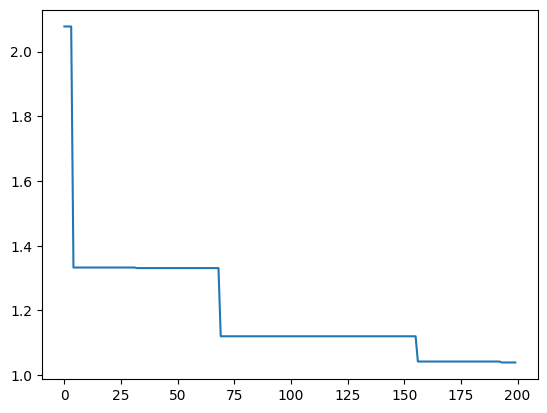

In [32]:
import matplotlib.pyplot as plt

plt.plot(losses[::5])
# plt.plot(population_loss_mean,',')

In [33]:
losses = np.array(losses)
with open("./losses/ga.bin",'wb') as file:
    losses.tofile(file)